# UTILS

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.special import ive        # normalized Bessel function
from scipy.integrate import quad     # compute integral between x and y (possibly = to + ∞)
from sklearn import datasets
from sklearn import preprocessing

In [137]:
# P-VALUE KERNEL

# Define the Marcum integrand used in the "quad" function, see "generalized_marcum"
def Q_marcum_integrand(x, nu, a, b):
    return (1 / a)**(nu-1) * x ** nu * np.exp(-0.5 * (x**2 + a**2)) * ive(nu-1, a * x)

def generalized_marcum(nu, a, b):
  int_with_param = lambda x: Q_marcum_integrand(x, nu, a, b)
  int_value, int_error = quad(int_with_param, b, np.inf)       # returns the value of the integral between b and + ∞ and an estimation of the error with the true value
  return int_value

# for the definition, see Bompais, M., Ameur, H., Pastor, D. and Dupraz, E., 2018, June. The p-value as a new similarity function for spectral clustering in sensor networks. In 2018 IEEE Statistical Signal Processing Workshop (SSP) (pp. 95-99). IEEE.
def pvalue_weight(y1, y2, β1, β2, sigma):
  return generalized_marcum(len(y1)/2, np.min([β1, β2]) / sigma, np.linalg.norm(y1 - y2) / sigma)

In [138]:
# GAUSSIAN KERNEL

# M-nearest neighbor estimate of the local sigma
def compute_β(V, y, M):
    assert M <= len(V), "M must be at most len(V)"
    norm_list = np.array([np.linalg.norm(vi-y) for vi in V])
    norm_list = norm_list[norm_list > 0]
    norm_list.sort()
    return np.sum(norm_list[:M]) / M

# Gaussian kernel with the M-nearest neighbor estimate
def gaussian_kernel(y1, y2, β1, β2):
    return np.exp(-np.linalg.norm(y1 - y2)**2 / (β1 * β2))

# Gaussian kernel without the M-nearest neighbor estimate
def gaussian_kernel2(y1, y2, sigma):
    return np.exp(-0.5 * np.linalg.norm(y1 - y2)**2 / sigma**2)

In [139]:
# SIMILARITY, DEGREE AND LAPLACIAN MATRIX

def compute_similarity_matrix(similarity_function="gaussian", **kw_args):
    if similarity_function=="gaussian":
        V, M = kw_args["compute_β"]
        # sigma = kw_args["sigma"]
        N = len(V)
        res = np.zeros((N, N))
        for i in range(N):
            for j in range(i+1, N):
                βi = compute_β(V, V[i], M)
                βj = compute_β(V, V[j], M)
                loc_value = gaussian_kernel(V[i], V[j], βi, βj)
                # loc_value = gaussian_kernel2(V[i], V[j], sigma)
                res[i, j] = loc_value
                res[j, i] = loc_value
        res = np.maximum(res, res.T)
        return res
    else: #p-value
        V, M = kw_args["compute_β"]
        sigma = kw_args["RDT_sigma"]
        N = len(V)
        res = np.zeros((N, N))
        for i in range(N):
            for j in range(i+1, N):
                βi = compute_β(V, V[i], M)
                βj = compute_β(V, V[j], M)
                loc_value = pvalue_weight(V[i], V[j], βi, βj, sigma * np.sqrt(2))
                res[i, j] = loc_value
                res[j, i] = loc_value
        res = np.maximum(res, res.T)
        return res

def compute_D(similarity_matrix):
    return np.diag(np.sum(similarity_matrix, axis=1))

def compute_laplacian(similarity_function="gaussian", **kw_args):
    S = compute_similarity_matrix(similarity_function=similarity_function, **kw_args)
    D = compute_D(S)
    return D - S

def compute_laplacian_normalized(similarity_function="gaussian", **kw_args):
    S = compute_similarity_matrix(similarity_function=similarity_function, **kw_args)
    D = compute_D(S)
    Dinv = np.linalg.inv(D)**(0.5)
    return Dinv @ S @ Dinv

In [140]:
# THE HISTOGRAM HEURISTIC FUNCTION

# test_bins is the value that you can fit, which is a segmentation of the interval so that you can
# discriminate between a noise and an identity vector

def get_ker_vec_hist_heuristic(eig_vec, test_bins):
  res = []
  N = eig_vec.shape[0]
  for i in range(N):
    count, bins = np.histogram(eig_vec[:, i], bins=test_bins)
    test_value = len(count[count != 0])
    if test_value <= 3:
      res.append(eig_vec[:, i])
  return np.array(res)

In [141]:
# OBSERVATION FUNCTION DEFINITION
def observe_smooth_circles(ns, *R):
    nR = len(R)
    thres = ns // nR
    res = np.zeros((thres * nR, 2))
    for i in range(ns):

        θ = np.linspace(0, 2*np.pi, thres)

        for i in range(thres * nR):
            iR = i//thres
            iθ = i % thres
            res[i, 0] = R[iR] * np.cos(θ[iθ])
            res[i, 1] = R[iR] * np.sin(θ[iθ])
    return res

def observe_smooth_circles_noisy(ns, sigma, *R):
    nR = len(R)
    thres = ns // nR
    res = np.zeros((thres * nR, 2))
    for i in range(ns):

        θ = np.linspace(0, 2*np.pi, thres)

        for i in range(thres * nR):
            iR = i//thres
            iθ = i % thres
            res[i, 0] = R[iR] * np.cos(θ[iθ]) + sigma * np.random.normal(0, sigma)
            res[i, 1] = R[iR] * np.sin(θ[iθ]) + sigma * np.random.normal(0, sigma)
    return res

def create_data(nsample, sigma):
    X, z = datasets.make_moons(n_samples=nsample, noise=sigma, random_state=0)
    # Generates toy data (moon-shaped data points) and labels
    sc = preprocessing.StandardScaler()  # StandardScaler standardizes features by removing the mean and scaling to unit variance
    sc.fit(X)  # Compute the mean and standard deviation to be used for later scaling
    X_norm = sc.transform(X)  # Standardize features by subtracting the mean and scaling to unit variance
    return X_norm, z

# TESTS

## GIVEN THE NUMBER OF CLUSTERS K

In [142]:
def compute_k_clusters_unnormalized(similarity_function, k, **kw): 
    # compute un-normalized laplacian
    L = compute_laplacian(similarity_function=similarity_function, **kw)
    # compute the eigenvectors and eigenvalues of the laplacian
    val, vec = np.linalg.eig(L)
    # sort eigenvalues
    idx = val.argsort()
    val = val[idx]
    vec = vec[:, idx]
    # take the eigenvectors corresponding to the k smallest eigenvalues
    U = vec[:, :k]
    kmeans = KMeans(n_clusters = k, n_init=10)
    kmeans.fit(U)
    return kmeans.predict(U)

def compute_k_clusters_normalized(similarity_function, k, **kw):
    # compute normalized laplacian
    L_norm = compute_laplacian_normalized(similarity_function=similarity_function, **kw)
    # compute the eigenvectors and eigenvalues of the normalized laplacian
    val_norm, vec_norm = np.linalg.eig(L_norm)
    # sort eigenvalues
    idx_norm = val_norm.argsort()
    val_norm = val_norm[idx_norm]
    vec_norm = vec_norm[:, idx_norm]
    # take the eigenvectors corresponding to the k smallest eigenvalues
    U_norm = vec_norm[:, :k]
    kmeans_norm = KMeans(n_clusters = k, n_init=10)
    kmeans_norm.fit(U_norm)
    return kmeans_norm.predict(U_norm)


### GAUSSIAN KERNEL

#### WITHOUT NOISE

##### Concentric cercles

In [143]:
# USING CONCENTRIC CIRCLES -----------------------------------------------------

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Create data
obs = observe_smooth_circles(200,1,5,11)


# define function parameters
kw = {"compute_β": [obs,3]}

# define the number of clusters
k = 3


# USING UN-NORMALIZED LAPLACIAN ------------------------------------------------
clusters = compute_k_clusters_unnormalized("gaussian", k, **kw)
# ------------------------------------------------------------------------------

# USING NORMALIZED LAPLACIAN ---------------------------------------------------
clusters_norm = compute_k_clusters_normalized("gaussian", k, **kw)
# ------------------------------------------------------------------------------


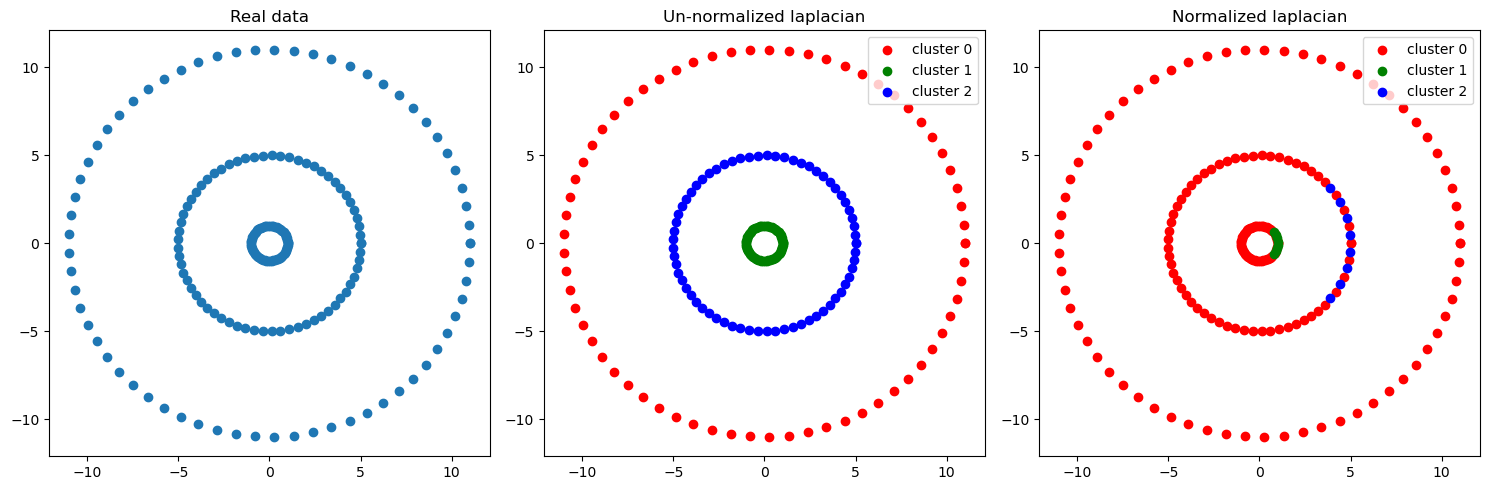

In [144]:
# plot the real data, the clusters using the un-normalized laplacian and the normalized laplacian in three subplots
colors = ["red", "green", "blue", "yellow", "cyan", "purple", "brown", "pink", "olive"]
fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("Real data")
plt.scatter(obs[:, 0], obs[:, 1])
plt.subplot(132)
plt.title("Un-normalized laplacian")
for i in range(k):
    res = obs[clusters==i]
    plt.scatter(res[:, 0], res[:, 1], c=colors[i], label=f"cluster {i}") # in case there are few classes
plt.legend()
plt.subplot(133)
plt.title("Normalized laplacian")
for i in range(k):
    res = obs[clusters_norm==i]
    plt.scatter(res[:, 0], res[:, 1], c=colors[i], label=f"cluster {i}") # in case there are few classes
plt.legend()
plt.tight_layout()

# creat results folder if it does not exist 
import os
if not os.path.exists("results"):
    os.makedirs("results")

# save the plot
plt.savefig("results/k_known_gaussain_no_noise_concentric_cercles.png")

plt.show()
# ------------------------------------------------------------------------------

##### Moons dataset

In [145]:
# USING MOONS DATASET ----------------------------------------------------------
# Create data
X, z = create_data(200, 0.05)

# define function parameters
kw = {"compute_β": [X,3]}
# calculate the similarity matrix, degree matrix and Laplacian matrix
L = compute_laplacian("gaussian", **kw)

# calculate the eigenvalues and eigenvectors of the Laplacian matrix
eig_val, eig_vec = np.linalg.eigh(L)
eig_val = np.abs(eig_val)             # needed in case one eigen value is complex for some reason
eig_vec = np.abs(eig_vec)             # ""

# define the number of clusters
k = 2

# USING UN-NORMALIZED LAPLACIAN ------------------------------------------------
clusters = compute_k_clusters_unnormalized("gaussian", k, **kw)

# USING NORMALIZED LAPLACIAN ---------------------------------------------------
clusters_norm = compute_k_clusters_normalized("gaussian", k, **kw)

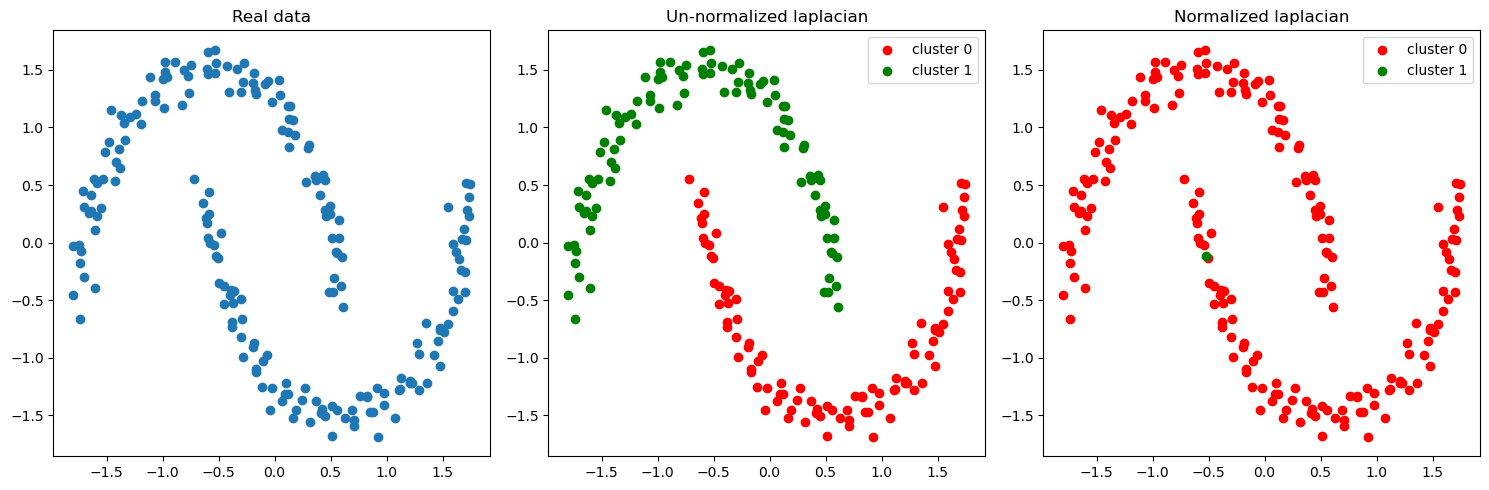

In [146]:
# plot the real data, the clusters using the un-normalized laplacian and the normalized laplacian in three subplots
colors = ["red", "green", "blue", "yellow", "cyan", "purple", "brown", "pink", "olive"]
fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("Real data")
plt.scatter(X[:, 0], X[:, 1])
plt.subplot(132)
plt.title("Un-normalized laplacian")
for i in range(k):
    res = X[clusters==i]
    plt.scatter(res[:, 0], res[:, 1], c=colors[i], label=f"cluster {i}") # in case there are few classes
plt.legend()
plt.subplot(133)
plt.title("Normalized laplacian")
for i in range(k):
    res = X[clusters_norm==i]
    plt.scatter(res[:, 0], res[:, 1], c=colors[i], label=f"cluster {i}") # in case there are few classes
plt.legend()
plt.tight_layout()

# creat results folder if it does not exist 
import os
if not os.path.exists("results"):
    os.makedirs("results")

# save the plot
plt.savefig("results/k_known_gaussain_no_noise_moons_dataset.png")

plt.show()
# ------------------------------------------------------------------------------

#### WITH NOISE

##### Concentric cercles

In [147]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Create data
obs = observe_smooth_circles_noisy(200,0.5,1,5,11)

# define function parameters
kw = {"compute_β": [obs,3]}

# # calculate the similarity matrix, degree matrix and Laplacian matrix
# L = compute_laplacian("gaussian", **kw)

# calculate the eigenvalues and eigenvectors of the Laplacian matrix
eig_val, eig_vec = np.linalg.eigh(L)
eig_val = np.abs(eig_val)             # needed in case one eigen value is complex for some reason
eig_vec = np.abs(eig_vec)             # ""

# define the number of clusters
k = 3

# compute clusters with known number of clusters
# USING UN-NORMALIZED LAPLACIAN ------------------------------------------------
clusters = compute_k_clusters_unnormalized("gaussian", k, **kw)
# ------------------------------------------------------------------------------

# USING NORMALIZED LAPLACIAN ---------------------------------------------------
clusters_norm = compute_k_clusters_normalized("gaussian", k, **kw)
# ------------------------------------------------------------------------------

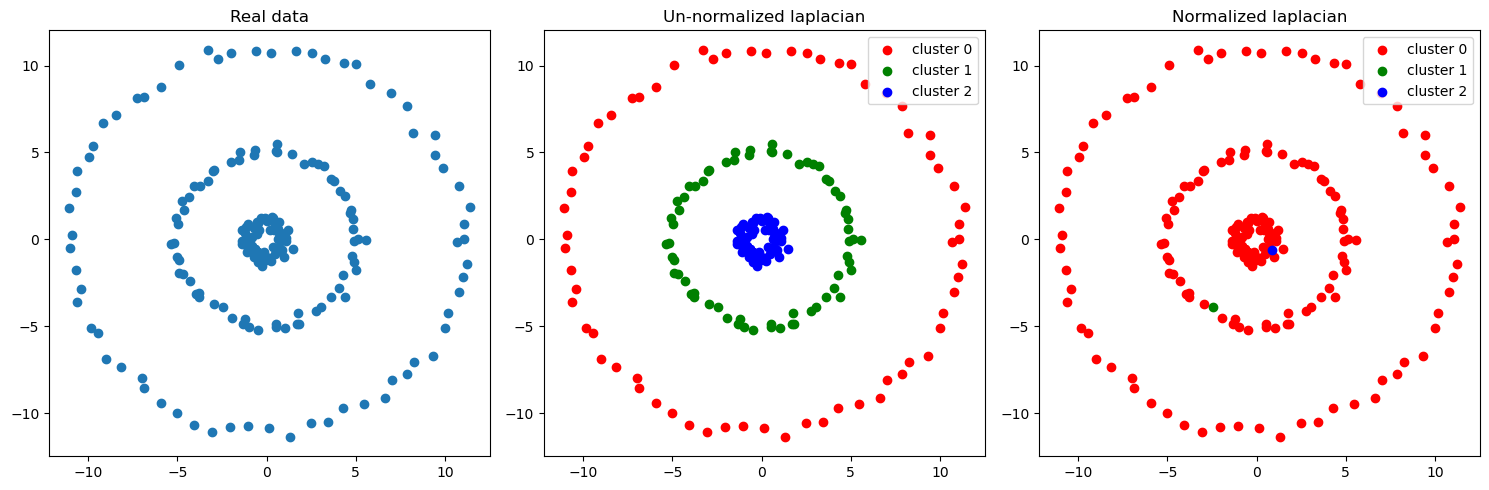

In [148]:
# plot the real data, the clusters using the un-normalized laplacian and the normalized laplacian in three subplots
colors = ["red", "green", "blue", "yellow", "cyan", "purple", "brown", "pink", "olive"]
fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("Real data")
plt.scatter(obs[:, 0], obs[:, 1])
plt.subplot(132)
plt.title("Un-normalized laplacian")
for i in range(k):
    res = obs[clusters==i]
    plt.scatter(res[:, 0], res[:, 1], c=colors[i], label=f"cluster {i}") # in case there are few classes
plt.legend()
plt.subplot(133)
plt.title("Normalized laplacian")
for i in range(k):
    res = obs[clusters_norm==i]
    plt.scatter(res[:, 0], res[:, 1], c=colors[i], label=f"cluster {i}") # in case there are few classes
plt.legend()
plt.tight_layout()

# creat results folder if it does not exist 
import os
if not os.path.exists("results"):
    os.makedirs("results")

# save the plot
plt.savefig("results/k_known_gaussain_with_noise_concentric_cercles.png")

plt.show()
# ------------------------------------------------------------------------------

##### Moons dataset

In [149]:
# USING MOONS DATASET ----------------------------------------------------------
# Create data
X, z = create_data(200, 0.08)

# define function parameters
kw = {"compute_β": [X,3]}
# calculate the similarity matrix, degree matrix and Laplacian matrix
L = compute_laplacian("gaussian", **kw)

# calculate the eigenvalues and eigenvectors of the Laplacian matrix
eig_val, eig_vec = np.linalg.eigh(L)
eig_val = np.abs(eig_val)             # needed in case one eigen value is complex for some reason
eig_vec = np.abs(eig_vec)             # ""

# define the number of clusters
k = 2

# USING UN-NORMALIZED LAPLACIAN ------------------------------------------------
clusters = compute_k_clusters_unnormalized("gaussian", k, **kw)

# USING NORMALIZED LAPLACIAN ---------------------------------------------------
clusters_norm = compute_k_clusters_normalized("gaussian", k, **kw)

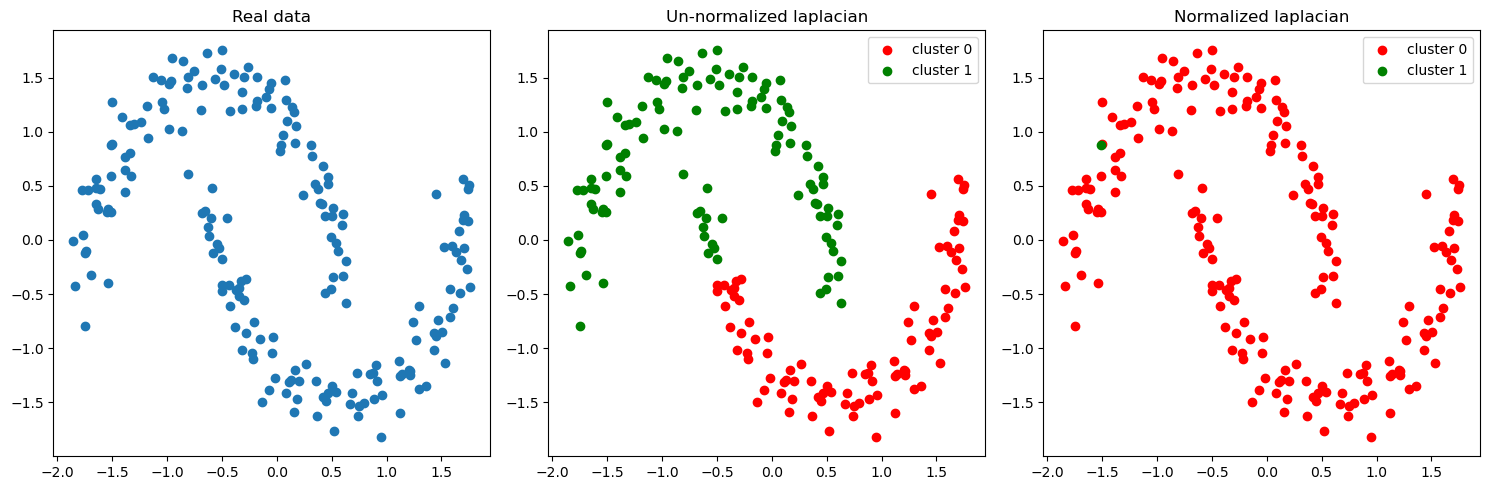

In [150]:
# plot the real data, the clusters using the un-normalized laplacian and the normalized laplacian in three subplots
colors = ["red", "green", "blue", "yellow", "cyan", "purple", "brown", "pink", "olive"]
fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("Real data")
plt.scatter(X[:, 0], X[:, 1])
plt.subplot(132)
plt.title("Un-normalized laplacian")
for i in range(k):
    res = X[clusters==i]
    plt.scatter(res[:, 0], res[:, 1], c=colors[i], label=f"cluster {i}") # in case there are few classes
plt.legend()
plt.subplot(133)
plt.title("Normalized laplacian")
for i in range(k):
    res = X[clusters_norm==i]
    plt.scatter(res[:, 0], res[:, 1], c=colors[i], label=f"cluster {i}") # in case there are few classes
plt.legend()
plt.tight_layout()

# creat results folder if it does not exist 
import os
if not os.path.exists("results"):
    os.makedirs("results")

# save the plot
plt.savefig("results/k_known_gaussain_with_noise_moons_dataset.png")

plt.show()
# ------------------------------------------------------------------------------

#### WITH EXTREME NOISE

##### Concentric cercles

In [151]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Create data
obs = observe_smooth_circles_noisy(200,0.8,1,5,11)

# define function parameters
kw = {"compute_β": [obs,3]}

# # calculate the similarity matrix, degree matrix and Laplacian matrix
# L = compute_laplacian("gaussian", **kw)

# calculate the eigenvalues and eigenvectors of the Laplacian matrix
eig_val, eig_vec = np.linalg.eigh(L)
eig_val = np.abs(eig_val)             # needed in case one eigen value is complex for some reason
eig_vec = np.abs(eig_vec)             # ""

# define the number of clusters
k = 3

# compute clusters with known number of clusters
# USING UN-NORMALIZED LAPLACIAN ------------------------------------------------
clusters = compute_k_clusters_unnormalized("gaussian", k, **kw)
# ------------------------------------------------------------------------------

# USING NORMALIZED LAPLACIAN ---------------------------------------------------
clusters_norm = compute_k_clusters_normalized("gaussian", k, **kw)
# ------------------------------------------------------------------------------

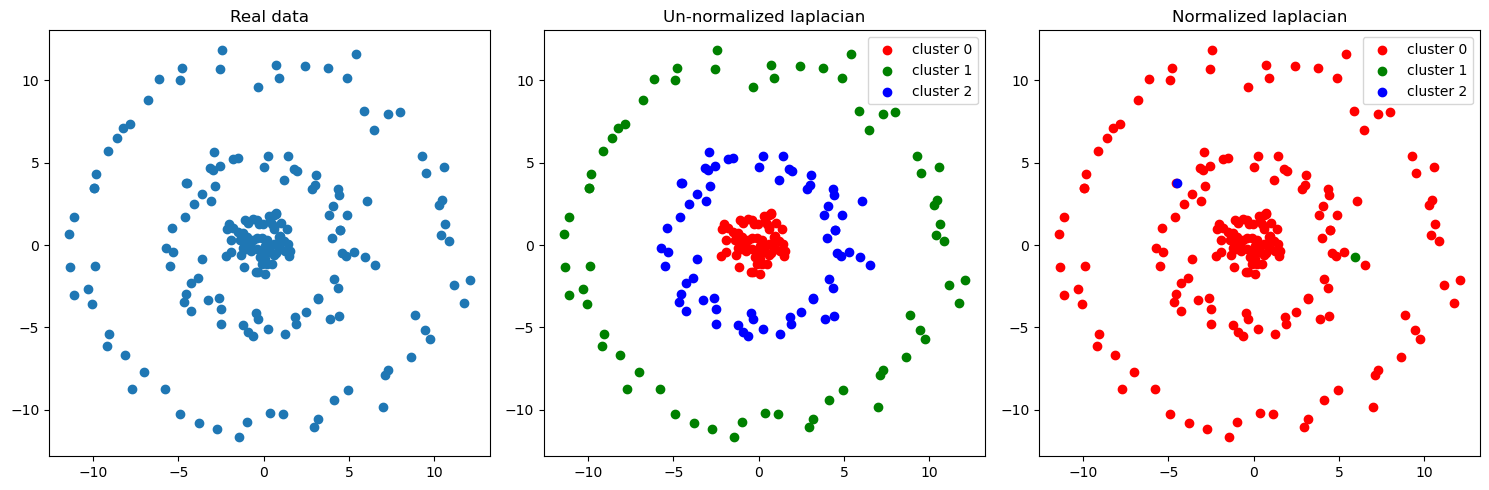

In [152]:
# plot the real data, the clusters using the un-normalized laplacian and the normalized laplacian in three subplots
colors = ["red", "green", "blue", "yellow", "cyan", "purple", "brown", "pink", "olive"]
fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("Real data")
plt.scatter(obs[:, 0], obs[:, 1])
plt.subplot(132)
plt.title("Un-normalized laplacian")
for i in range(k):
    res = obs[clusters==i]
    plt.scatter(res[:, 0], res[:, 1], c=colors[i], label=f"cluster {i}") # in case there are few classes
plt.legend()
plt.subplot(133)
plt.title("Normalized laplacian")
for i in range(k):
    res = obs[clusters_norm==i]
    plt.scatter(res[:, 0], res[:, 1], c=colors[i], label=f"cluster {i}") # in case there are few classes
plt.legend()
plt.tight_layout()

# creat results folder if it does not exist 
import os
if not os.path.exists("results"):
    os.makedirs("results")

# save the plot
plt.savefig("results/k_known_gaussain_with__extreme_noise_concentric_cercles.png")

plt.show()
# ------------------------------------------------------------------------------

##### Moons dataset

In [153]:
# USING MOONS DATASET ----------------------------------------------------------
# Create data
X, z = create_data(200, 0.12)

# define function parameters
kw = {"compute_β": [X,3]}
# calculate the similarity matrix, degree matrix and Laplacian matrix
L = compute_laplacian("gaussian", **kw)

# calculate the eigenvalues and eigenvectors of the Laplacian matrix
eig_val, eig_vec = np.linalg.eigh(L)
eig_val = np.abs(eig_val)             # needed in case one eigen value is complex for some reason
eig_vec = np.abs(eig_vec)             # ""

# define the number of clusters
k = 2

# USING UN-NORMALIZED LAPLACIAN ------------------------------------------------
clusters = compute_k_clusters_unnormalized("gaussian", k, **kw)

# USING NORMALIZED LAPLACIAN ---------------------------------------------------
clusters_norm = compute_k_clusters_normalized("gaussian", k, **kw)

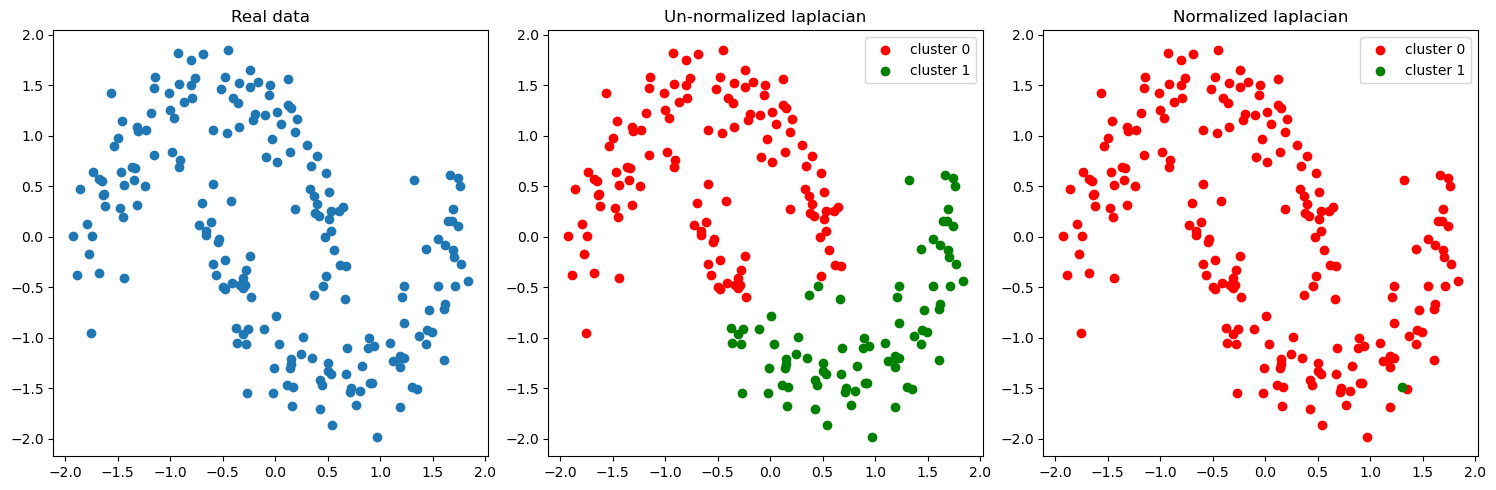

In [154]:
# plot the real data, the clusters using the un-normalized laplacian and the normalized laplacian in three subplots
colors = ["red", "green", "blue", "yellow", "cyan", "purple", "brown", "pink", "olive"]
fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("Real data")
plt.scatter(X[:, 0], X[:, 1])
plt.subplot(132)
plt.title("Un-normalized laplacian")
for i in range(k):
    res = X[clusters==i]
    plt.scatter(res[:, 0], res[:, 1], c=colors[i], label=f"cluster {i}") # in case there are few classes
plt.legend()
plt.subplot(133)
plt.title("Normalized laplacian")
for i in range(k):
    res = X[clusters_norm==i]
    plt.scatter(res[:, 0], res[:, 1], c=colors[i], label=f"cluster {i}") # in case there are few classes
plt.legend()
plt.tight_layout()
# creat results folder if it does not exist 
import os
if not os.path.exists("results"):
    os.makedirs("results")

# save the plot as image
plt.savefig("results/k_known_gaussain_with_extreme_noise_moons_dataset.png")

plt.show()
# ------------------------------------------------------------------------------

### P-VALUE

#### WITHOUT NOISE

##### Concentric cercles

In [155]:
sigmaRDT = 0.3

# USING CONCENTRIC CIRCLES -----------------------------------------------------

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Create data
obs = observe_smooth_circles(200,1,5,11)


# define function parameters
kw = {"compute_β": [obs,3], "RDT_sigma": sigmaRDT}

# define the number of clusters
k = 3


# USING UN-NORMALIZED LAPLACIAN ------------------------------------------------
clusters = compute_k_clusters_unnormalized("p-value", k, **kw)
# ------------------------------------------------------------------------------

# USING NORMALIZED LAPLACIAN ---------------------------------------------------
clusters_norm = compute_k_clusters_normalized("p-value", k, **kw)
# ------------------------------------------------------------------------------


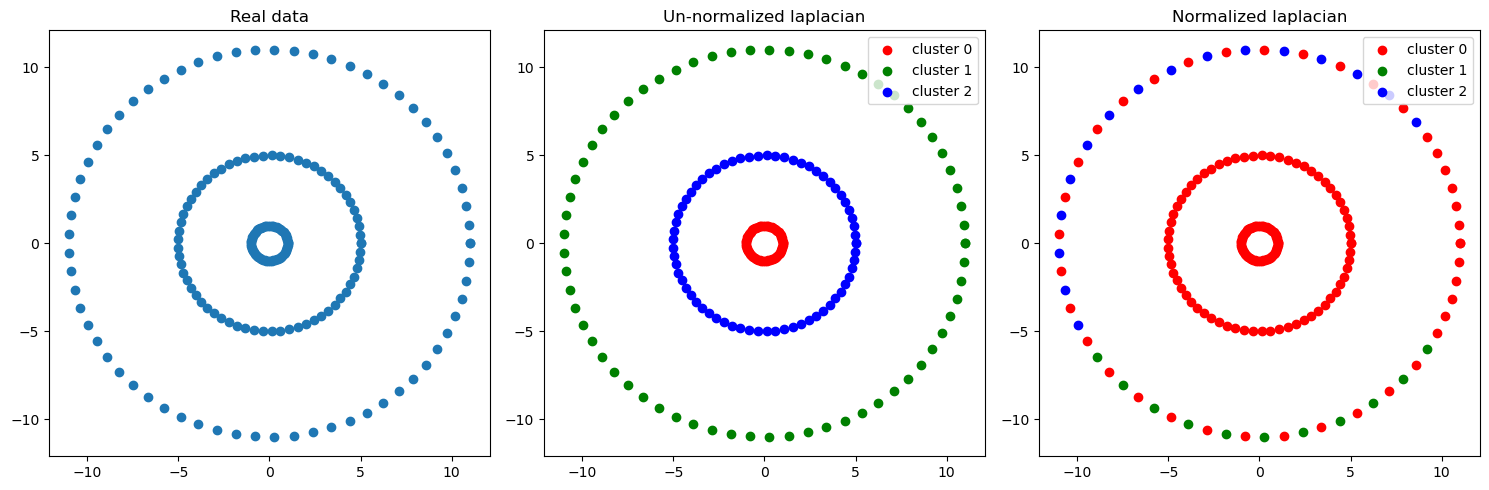

In [156]:
# plot the real data, the clusters using the un-normalized laplacian and the normalized laplacian in three subplots
colors = ["red", "green", "blue", "yellow", "cyan", "purple", "brown", "pink", "olive"]
fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("Real data")
plt.scatter(obs[:, 0], obs[:, 1])
plt.subplot(132)
plt.title("Un-normalized laplacian")
for i in range(k):
    res = obs[clusters==i]
    plt.scatter(res[:, 0], res[:, 1], c=colors[i], label=f"cluster {i}") # in case there are few classes
plt.legend()
plt.subplot(133)
plt.title("Normalized laplacian")
for i in range(k):
    res = obs[clusters_norm==i]
    plt.scatter(res[:, 0], res[:, 1], c=colors[i], label=f"cluster {i}") # in case there are few classes
plt.legend()
plt.tight_layout()

# creat results folder if it does not exist 
import os
if not os.path.exists("results"):
    os.makedirs("results")

# save the plot
plt.savefig("results/k_known_p_value_no_noise_concentric_cercles.png")

plt.show()
# ------------------------------------------------------------------------------

##### Moons dataset

In [157]:
# USING MOONS DATASET ----------------------------------------------------------
# Create data
X, z = create_data(200, 0.05)

sigmaRDT = 0.3

# define function parameters
kw = {"compute_β": [X,3], "RDT_sigma": sigmaRDT}

# define the number of clusters
k = 2

# USING UN-NORMALIZED LAPLACIAN ------------------------------------------------
clusters = compute_k_clusters_unnormalized("p-value", k, **kw)

# USING NORMALIZED LAPLACIAN ---------------------------------------------------
clusters_norm = compute_k_clusters_normalized("p-value", k, **kw)

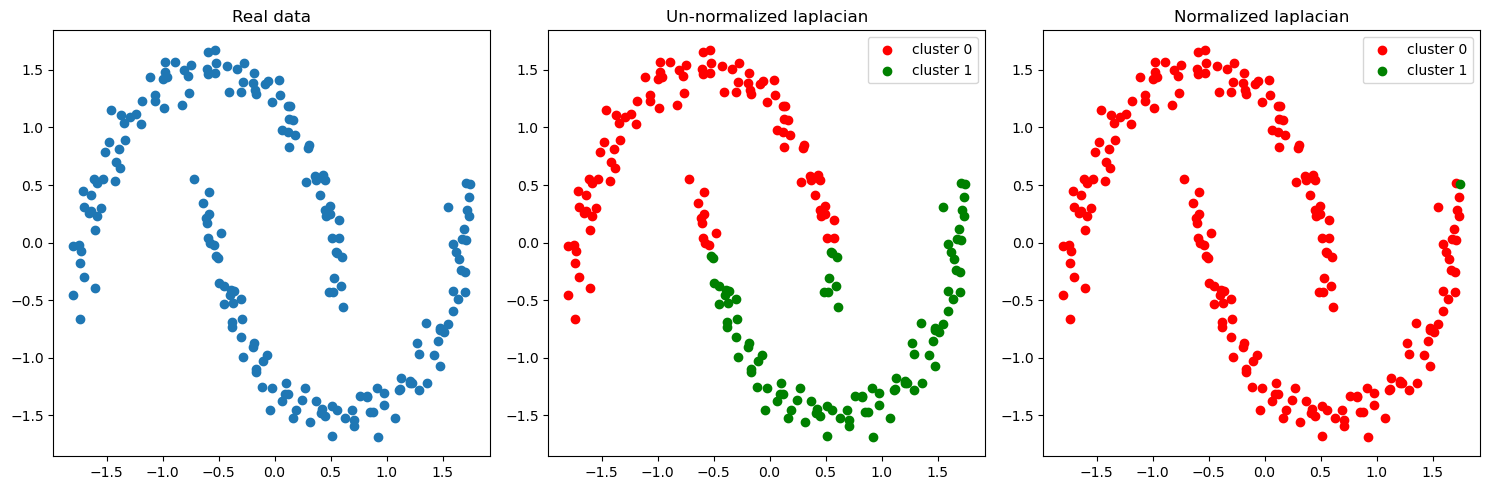

In [158]:
# plot the real data, the clusters using the un-normalized laplacian and the normalized laplacian in three subplots
colors = ["red", "green", "blue", "yellow", "cyan", "purple", "brown", "pink", "olive"]
fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("Real data")
plt.scatter(X[:, 0], X[:, 1])
plt.subplot(132)
plt.title("Un-normalized laplacian")
for i in range(k):
    res = X[clusters==i]
    plt.scatter(res[:, 0], res[:, 1], c=colors[i], label=f"cluster {i}") # in case there are few classes
plt.legend()
plt.subplot(133)
plt.title("Normalized laplacian")
for i in range(k):
    res = X[clusters_norm==i]
    plt.scatter(res[:, 0], res[:, 1], c=colors[i], label=f"cluster {i}") # in case there are few classes
plt.legend()
plt.tight_layout()

# creat results folder if it does not exist 
import os
if not os.path.exists("results"):
    os.makedirs("results")

# save the plot
plt.savefig("results/k_known_p_value_no_noise_moons_dataset.png")

plt.show()
# ------------------------------------------------------------------------------

#### WITH NOISE

##### Concentric cercles

In [159]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Create data
obs = observe_smooth_circles_noisy(200,0.5,1,5,11)

# define function parameters
kw = {"compute_β": [obs,3], "RDT_sigma": sigmaRDT}

# define the number of clusters
k = 3

# compute clusters with known number of clusters
# USING UN-NORMALIZED LAPLACIAN ------------------------------------------------
clusters = compute_k_clusters_unnormalized("p-value", k, **kw)
# ------------------------------------------------------------------------------

# USING NORMALIZED LAPLACIAN ---------------------------------------------------
clusters_norm = compute_k_clusters_normalized("p-value", k, **kw)
# ------------------------------------------------------------------------------

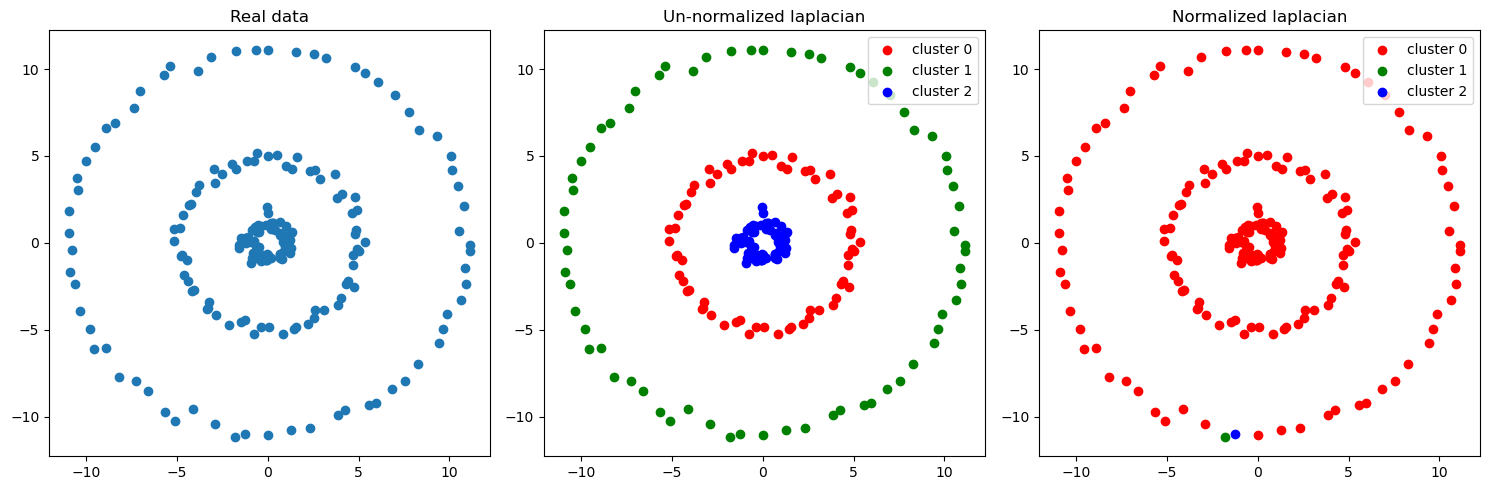

In [160]:
# plot the real data, the clusters using the un-normalized laplacian and the normalized laplacian in three subplots
colors = ["red", "green", "blue", "yellow", "cyan", "purple", "brown", "pink", "olive"]
fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("Real data")
plt.scatter(obs[:, 0], obs[:, 1])
plt.subplot(132)
plt.title("Un-normalized laplacian")
for i in range(k):
    res = obs[clusters==i]
    plt.scatter(res[:, 0], res[:, 1], c=colors[i], label=f"cluster {i}") # in case there are few classes
plt.legend()
plt.subplot(133)
plt.title("Normalized laplacian")
for i in range(k):
    res = obs[clusters_norm==i]
    plt.scatter(res[:, 0], res[:, 1], c=colors[i], label=f"cluster {i}") # in case there are few classes
plt.legend()
plt.tight_layout()

# creat results folder if it does not exist 
import os
if not os.path.exists("results"):
    os.makedirs("results")

# save the plot
plt.savefig("results/k_known_p_value_with_noise_concentric_cercles.png")

plt.show()
# ------------------------------------------------------------------------------

##### Moons dataset

In [161]:
# USING MOONS DATASET ----------------------------------------------------------
# Create data
X, z = create_data(200, 0.08)

# define function parameters
kw = {"compute_β": [X,3], "RDT_sigma": sigmaRDT}

# define the number of clusters
k = 2

# USING UN-NORMALIZED LAPLACIAN ------------------------------------------------
clusters = compute_k_clusters_unnormalized("p-value", k, **kw)

# USING NORMALIZED LAPLACIAN ---------------------------------------------------
clusters_norm = compute_k_clusters_normalized("p-value", k, **kw)

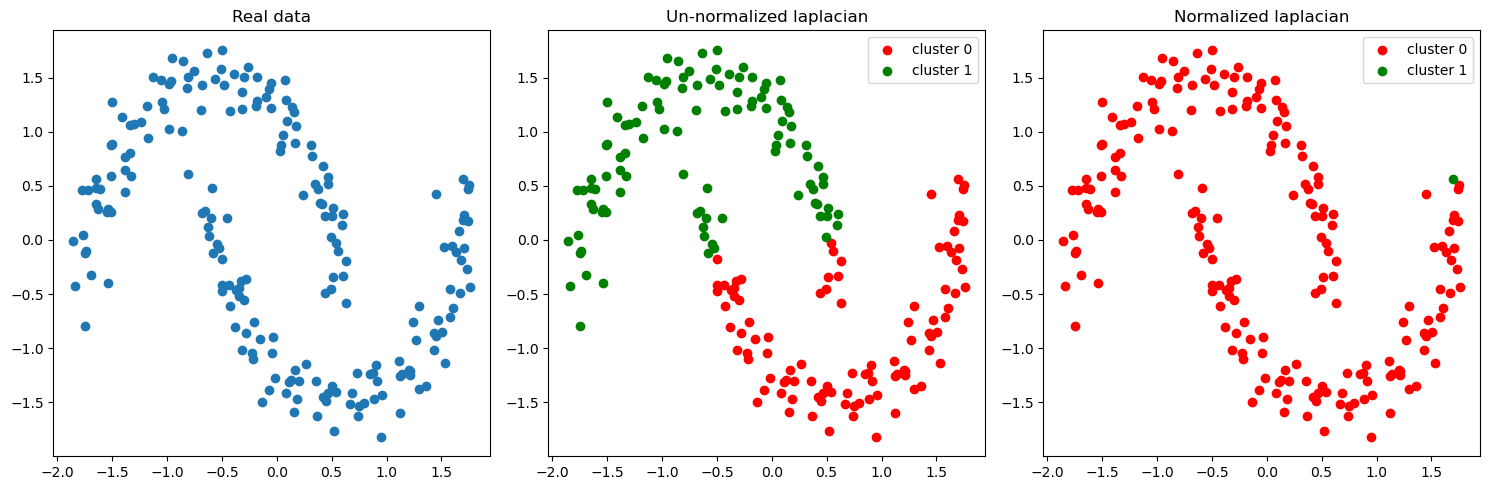

In [162]:
# plot the real data, the clusters using the un-normalized laplacian and the normalized laplacian in three subplots
colors = ["red", "green", "blue", "yellow", "cyan", "purple", "brown", "pink", "olive"]
fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("Real data")
plt.scatter(X[:, 0], X[:, 1])
plt.subplot(132)
plt.title("Un-normalized laplacian")
for i in range(k):
    res = X[clusters==i]
    plt.scatter(res[:, 0], res[:, 1], c=colors[i], label=f"cluster {i}") # in case there are few classes
plt.legend()
plt.subplot(133)
plt.title("Normalized laplacian")
for i in range(k):
    res = X[clusters_norm==i]
    plt.scatter(res[:, 0], res[:, 1], c=colors[i], label=f"cluster {i}") # in case there are few classes
plt.legend()
plt.tight_layout()

# creat results folder if it does not exist 
import os
if not os.path.exists("results"):
    os.makedirs("results")

# save the plot
plt.savefig("results/k_known_p_value_with_noise_moons_dataset.png")

plt.show()
# ------------------------------------------------------------------------------

#### WITH EXTREME NOISE

##### Concentric cercles

In [163]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Create data
obs = observe_smooth_circles_noisy(200,0.8,1,5,11)

# define function parameters
kw = {"compute_β": [obs,3], "RDT_sigma": sigmaRDT}

# define the number of clusters
k = 3

# compute clusters with known number of clusters
# USING UN-NORMALIZED LAPLACIAN ------------------------------------------------
clusters = compute_k_clusters_unnormalized("p-value", k, **kw)
# ------------------------------------------------------------------------------

# USING NORMALIZED LAPLACIAN ---------------------------------------------------
clusters_norm = compute_k_clusters_normalized("p-value", k, **kw)
# ------------------------------------------------------------------------------

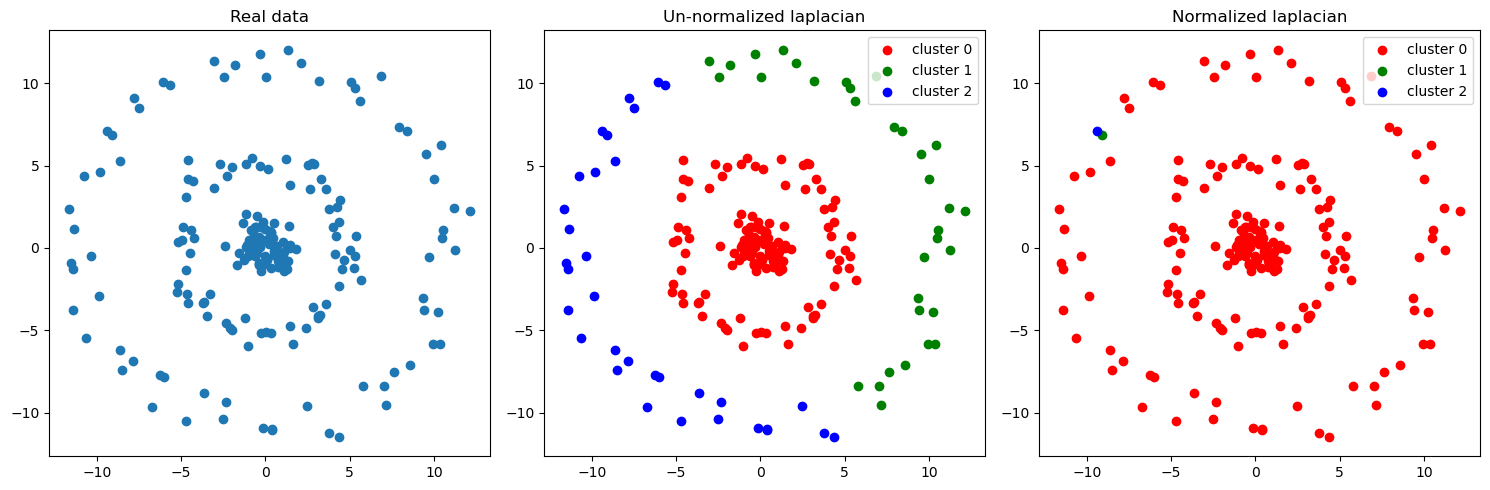

In [164]:
# plot the real data, the clusters using the un-normalized laplacian and the normalized laplacian in three subplots
colors = ["red", "green", "blue", "yellow", "cyan", "purple", "brown", "pink", "olive"]
fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("Real data")
plt.scatter(obs[:, 0], obs[:, 1])
plt.subplot(132)
plt.title("Un-normalized laplacian")
for i in range(k):
    res = obs[clusters==i]
    plt.scatter(res[:, 0], res[:, 1], c=colors[i], label=f"cluster {i}") # in case there are few classes
plt.legend()
plt.subplot(133)
plt.title("Normalized laplacian")
for i in range(k):
    res = obs[clusters_norm==i]
    plt.scatter(res[:, 0], res[:, 1], c=colors[i], label=f"cluster {i}") # in case there are few classes
plt.legend()
plt.tight_layout()

# creat results folder if it does not exist 
import os
if not os.path.exists("results"):
    os.makedirs("results")

# save the plot
plt.savefig("results/k_known_p_value_with__extreme_noise_concentric_cercles.png")

plt.show()
# ------------------------------------------------------------------------------

##### Moons dataset

In [165]:
# USING MOONS DATASET ----------------------------------------------------------
# Create data
X, z = create_data(200, 0.12)

# define function parameters
kw = {"compute_β": [X,3], "RDT_sigma": sigmaRDT}

# define the number of clusters
k = 2

# USING UN-NORMALIZED LAPLACIAN ------------------------------------------------
clusters = compute_k_clusters_unnormalized("p-value", k, **kw)

# USING NORMALIZED LAPLACIAN ---------------------------------------------------
clusters_norm = compute_k_clusters_normalized("p-value", k, **kw)

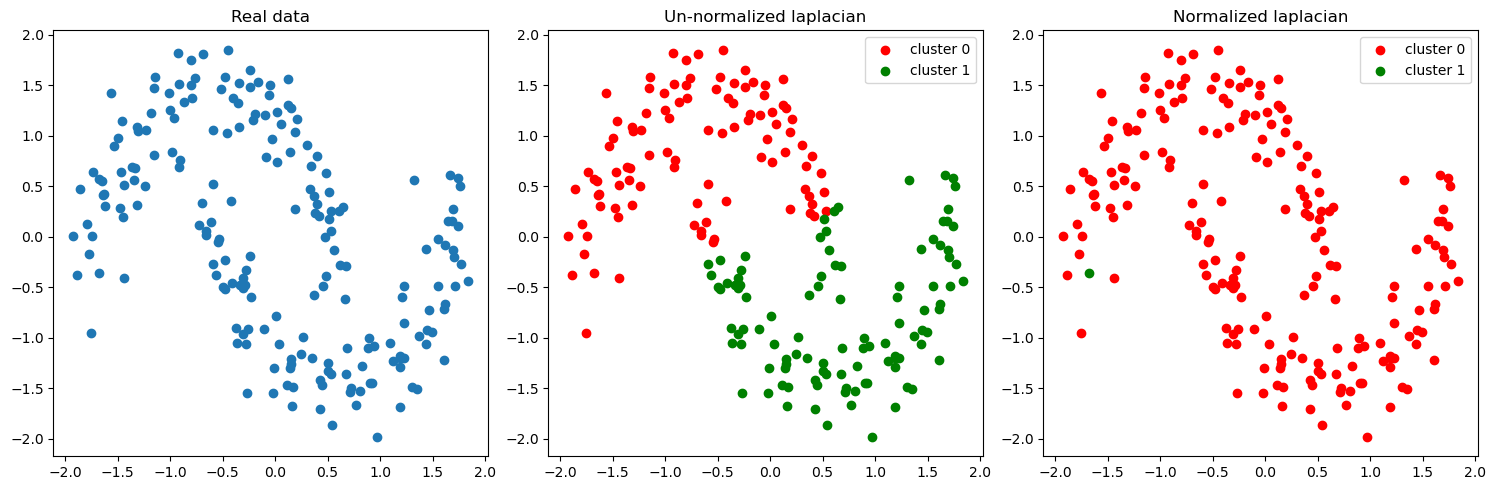

In [166]:
# plot the real data, the clusters using the un-normalized laplacian and the normalized laplacian in three subplots
colors = ["red", "green", "blue", "yellow", "cyan", "purple", "brown", "pink", "olive"]
fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("Real data")
plt.scatter(X[:, 0], X[:, 1])
plt.subplot(132)
plt.title("Un-normalized laplacian")
for i in range(k):
    res = X[clusters==i]
    plt.scatter(res[:, 0], res[:, 1], c=colors[i], label=f"cluster {i}") # in case there are few classes
plt.legend()
plt.subplot(133)
plt.title("Normalized laplacian")
for i in range(k):
    res = X[clusters_norm==i]
    plt.scatter(res[:, 0], res[:, 1], c=colors[i], label=f"cluster {i}") # in case there are few classes
plt.legend()
plt.tight_layout()
# creat results folder if it does not exist 
import os
if not os.path.exists("results"):
    os.makedirs("results")

# save the plot as image
plt.savefig("results/k_known_p_value_with_extreme_noise_moons_dataset.png")

plt.show()
# ------------------------------------------------------------------------------

## COMPARE RESULTS

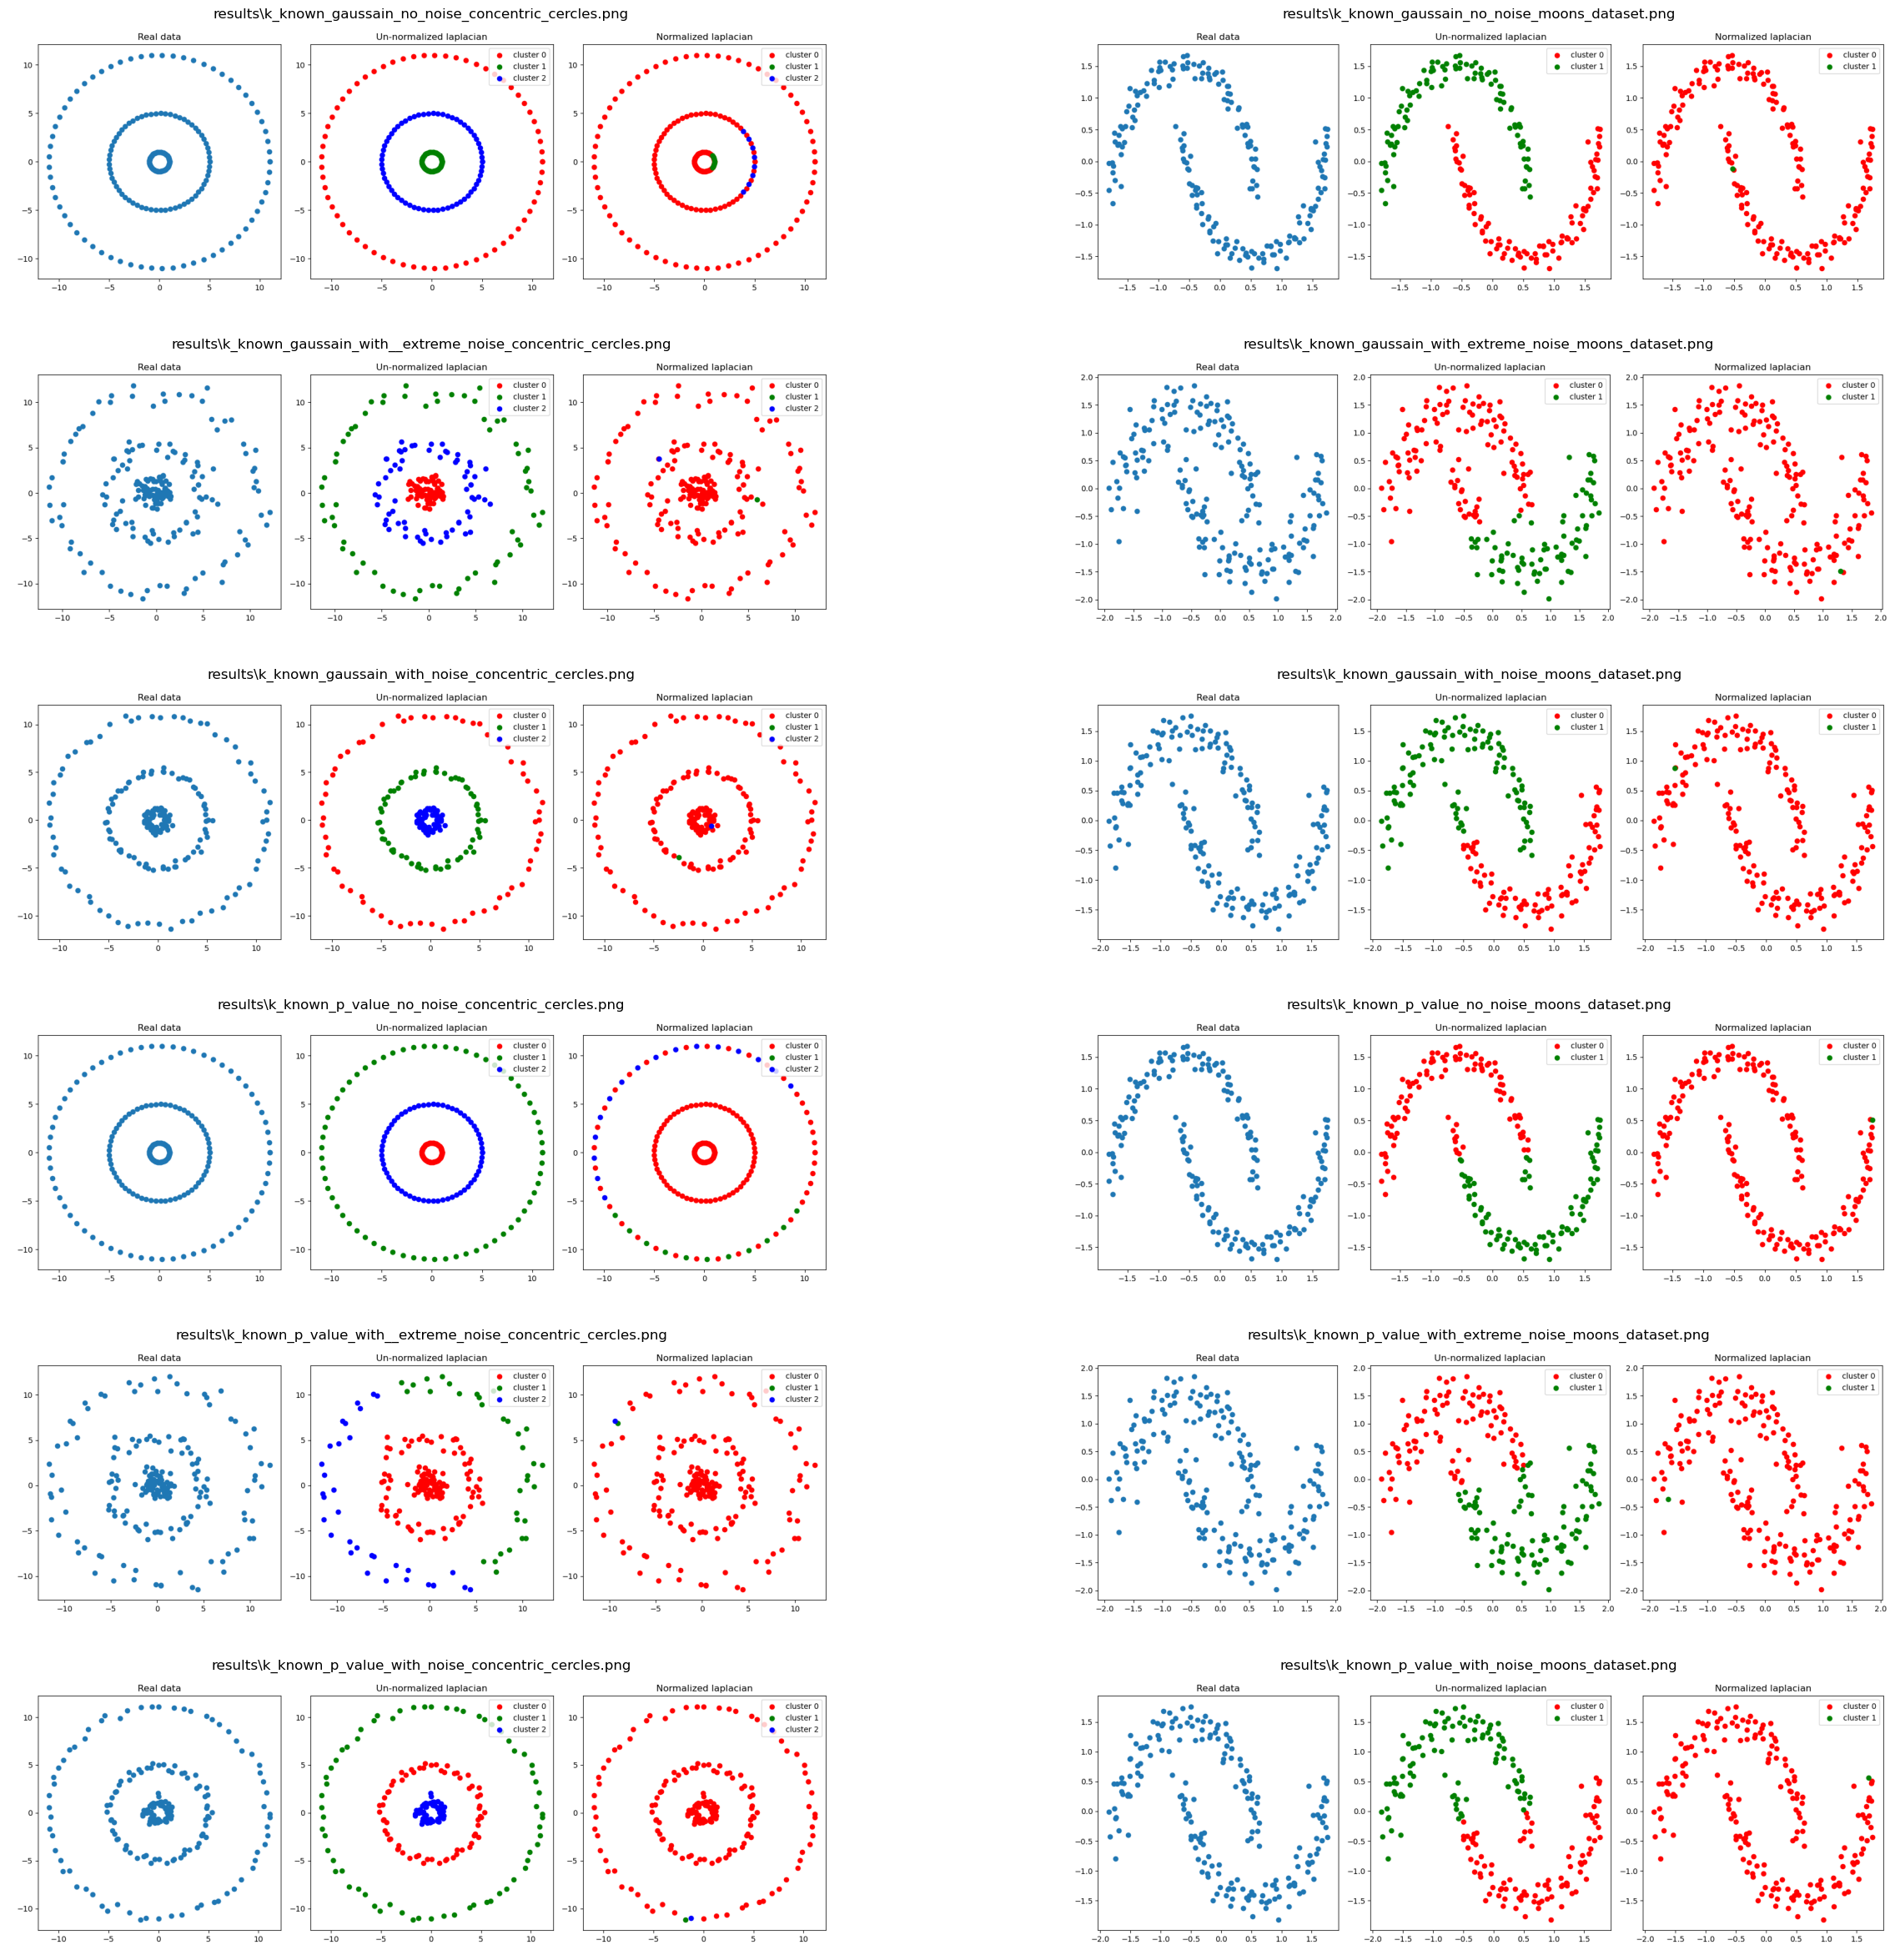

In [174]:
# read all images in the results folder
import PIL.Image as Image

images = []
for filename in os.listdir("results"):
    img = Image.open(os.path.join("results", filename))
    if img is not None:
        images.append(img)

# reorganize the images by name
images.sort(key=lambda x: x.filename)

# create a figure 6 by 2
fig = plt.subplots(6, 2, figsize=(30, 30))

# plot the images
for i in range(len(images)):
    plt.subplot(6, 2, i+1)
    plt.imshow(images[i])
    plt.title(images[i].filename)
    plt.axis("off")



# show the figure
plt.show()
# ------------------------------------------------------------------------------

## WITHOUT PRIOR KNOWLEDGE OF K

In [212]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Create data
obs = observe_smooth_circles_noisy(200,0.3,1,5,11)

# define function parameters
kw = {"compute_β": [obs,3], "RDT_sigma": sigmaRDT}

# calculate the similarity matrix, degree matrix and Laplacian matrix
L = compute_laplacian("p-value", **kw)

# calculate the eigenvalues and eigenvectors of the Laplacian matrix
eig_val, eig_vec = np.linalg.eigh(L)
eig_val = np.abs(eig_val)             # needed in case one eigen value is complex for some reason
eig_vec = np.abs(eig_vec)             # ""

# Unknow number of clusters
# use the get_ker_vec_hist_heuristic function to get the eigenvectors that are not noise
eig_vec_hist = get_ker_vec_hist_heuristic(eig_vec, 100)

In [213]:
eig_vec_hist.shape

(3, 198)

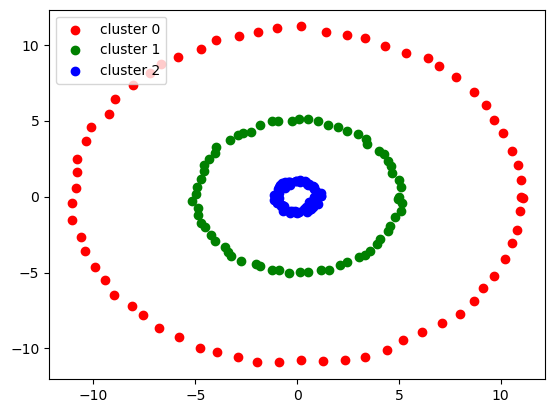

In [214]:
K = len(eig_vec_hist)
km = KMeans(n_clusters=K, n_init='auto')
km.fit(eig_vec_hist.T)
classes = km.predict(eig_vec_hist.T)

# SHOW THE RESULT
nb_classes = K
colors = ["red", "green", "blue", "yellow", "cyan", "purple", "brown", "pink", "olive"]

for i in range(nb_classes):
    Aauto = obs[classes==i]
    plt.scatter(Aauto[:, 0], Aauto[:, 1], c=colors[i], label=f"cluster {i}")
plt.legend()

In [215]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Create data
obs = observe_smooth_circles_noisy(200,0.3,1,5,11)

# define function parameters
kw = {"compute_β": [obs,3]}

# calculate the similarity matrix, degree matrix and Laplacian matrix
L = compute_laplacian("gaussian", **kw)

# calculate the eigenvalues and eigenvectors of the Laplacian matrix
eig_val, eig_vec = np.linalg.eigh(L)
eig_val = np.abs(eig_val)             # needed in case one eigen value is complex for some reason
eig_vec = np.abs(eig_vec)             # ""

# Unknow number of clusters
# use the get_ker_vec_hist_heuristic function to get the eigenvectors that are not noise
eig_vec_hist = get_ker_vec_hist_heuristic(eig_vec, 100)

In [216]:
eig_vec_hist.shape

(3, 198)

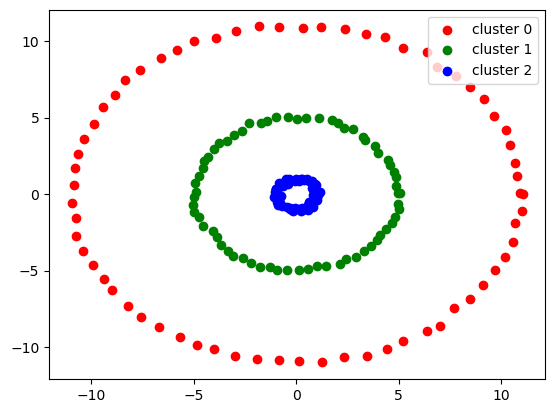

In [217]:
K = len(eig_vec_hist)
km = KMeans(n_clusters=K, n_init='auto')
km.fit(eig_vec_hist.T)
classes = km.predict(eig_vec_hist.T)

# SHOW THE RESULT
nb_classes = K
colors = ["red", "green", "blue", "yellow", "cyan", "purple", "brown", "pink", "olive"]

for i in range(nb_classes):
    Aauto = obs[classes==i]
    plt.scatter(Aauto[:, 0], Aauto[:, 1], c=colors[i], label=f"cluster {i}")
plt.legend()

In [250]:
# USING MOONS DATASET ----------------------------------------------------------
# Create data
X, z = create_data(200, 0.05)

# define function parameters
kw = {"compute_β": [X,3], "RDT_sigma": 0.00}
# calculate the similarity matrix, degree matrix and Laplacian matrix
L = compute_laplacian("gaussian", **kw)

# calculate the eigenvalues and eigenvectors of the Laplacian matrix
eig_val, eig_vec = np.linalg.eigh(L)

eig_vec_hist = get_ker_vec_hist_heuristic(eig_vec, 65)

In [252]:
eig_vec_hist.shape

(2, 200)

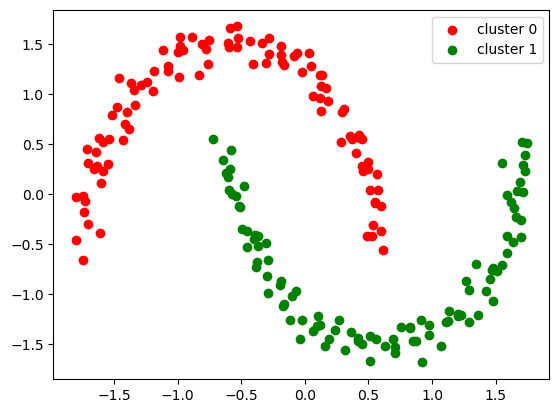

In [253]:
K = len(eig_vec_hist)
km = KMeans(n_clusters=K, n_init='auto')
km.fit(eig_vec_hist.T)
classes = km.predict(eig_vec_hist.T)

# SHOW THE RESULT
nb_classes = K
colors = ["red", "green", "blue", "yellow", "cyan", "purple", "brown", "pink", "olive"]

for i in range(nb_classes):
    Aauto = X[classes==i]
    plt.scatter(Aauto[:, 0], Aauto[:, 1], c=colors[i], label=f"cluster {i}")
plt.legend()

# EXTRA

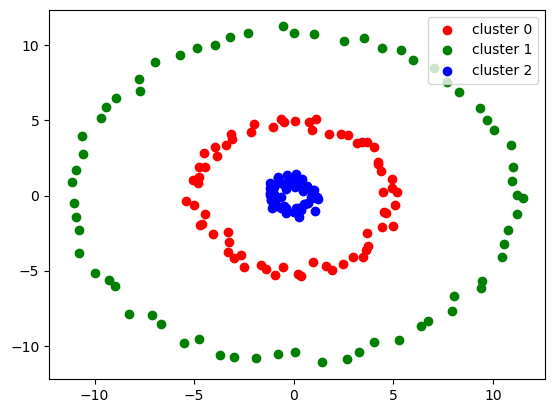

In [168]:
# DEFINITION OF OBSERVATIONS
# obs = observe_smooth_circles(200,1,4, 7, 10)

sigmaRDT = 0.3
obs = observe_smooth_circles_noisy(200, 0.5,1,5,11)
# obs, classGT = create_data(200, 0.1)
sigma = 0.5
kw = {"compute_β":[obs, 3], "RDT_sigma":sigmaRDT, "sigma": sigma}

# COMPUTATION OF LAPLACIAN

# UNCOMMENT THE CODE YOU WANT TO KEEP
# un-normalized Laplacian
L = compute_laplacian(similarity_function = "p-value", **kw) # you can change the kernel between "p-value" and "gaussian"

# normalized Laplacian (not working so well somehow, even by acknowledging that the expected eigen vectors are associated to 1 in this case)
# L = compute_laplacian_normalized(similarity_function = "gaussian", **kw)

# EIGEN VALUES AND VECTORS
eig_val, eig_vec = np.linalg.eig(L)
eig_val = np.abs(eig_val)             # needed in case one eigen value is complex for some reason
eig_vec = np.abs(eig_vec)             # ""


# UNCOMMENT THE CODE THAT APPLIES
# ESTIMATION OF THE EIGEN VECTORS FROM THE KERNEL OF L (histogram)
test_bins = 10000
res_eig = get_ker_vec_hist_heuristic(eig_vec, test_bins)

# ESTIMATION BY THREASHOLDING
# res_eig = eig_vec[eig_val < 10**(-4), :]

# PRIOR KNOWLEDGE OF K
# TODO


# KMEANS
# GET THE SUBSEQUENT CLASSES
K = len(res_eig)
km = KMeans(n_clusters=K, n_init='auto')
km.fit(res_eig.T)
classes = km.predict(res_eig.T)


# SHOW THE RESULT
nb_classes = K
colors = ["red", "green", "blue", "yellow", "cyan", "purple", "brown", "pink", "olive"]

for i in range(nb_classes):
    Aauto = obs[classes==i]
    plt.scatter(Aauto[:, 0], Aauto[:, 1], c=colors[i], label=f"cluster {i}") # in case there are few classes
    # plt.scatter(Aauto[:, 0], Aauto[:, 1], label=f"cluster {i}")            # in case you want to see all the classes to understand what is happening
plt.legend()